# ST7 Planification quotidienne d’une équipe mobile
# Phase III

## Importation de modules

In [1]:
# module importation
import numpy as np
from math import ceil
import matplotlib.pyplot as plt

# utilities
from utils import *
import random as rd
from copy import deepcopy

# model classes for employees and nodes
from models_v2 import Employee, Node, Task, Home, Unavail

Déclaration des constantes et des indices :

In [2]:
W = U = T = V = 0
employees = homes = tasks = unavails = nodes = []

## Fonction de lecture de données

In [3]:
def load_data_from_path(path_to_instance: str):
    # load employee data
    Employee.load_excel(path_to_instance)

    # load node data
    Node.clear_previous_data()
    for cls in [Home, Task, Unavail]:
        cls.load_excel(path_to_instance)
    Node.initialize_distance()

    # constants
    global W, U, T, V
    (W, U, T, V) = (Task.count, Unavail.count, Employee.count, Node.count)

    # indices of employees, homes, lunches, tasks, unavailabilities
    global employees, homes, tasks, unavails, nodes
    employees = list(range(T))
    homes = list(range(T))
    tasks = list(range(T, T + W))
    unavails = list((range(T + W, V)))
    nodes = list(range(V))

Lecture de données de test

In [4]:
path_to_test = path_bordeaux_v2 = "./data/InstancesV3/InstanceColumbiaV3.xlsx"
load_data_from_path(path_to_test)

## Implémentation de la classe Solution

In [21]:
from collections import deque

def index_to_employee(employee_idx):
    employee : Employee = Employee.list[employee_idx]
    return employee

def index_to_node(node_idx):
    return Node.list[node_idx]

def node_to_index(node: Node):
    for idx, node_cmp in enumerate(Node.list):
        if node == node_cmp:
            return idx

class GreedySolution:

    debug = True

    def __init__(self):
        # the indices of nodes that have not been visited
        self.unvisited_nodes = nodes[:]
        # indices of employees that are not home yet
        self.available_employees = employees[:]
        # employee_nodes[k] is the list of indices of tasks attributed to employee k, in the visit order
        # initially, only home
        self.employee_node_lists = {k: [] for k in employees}
        # unavailabilities that employee should visit + employee's home
        self.employee_unvisited_obstacles = {k: [] for k in employees}
        for k in employees:
            for unavail in Employee.list[k].unavails:
                self.employee_unvisited_obstacles[k].append(node_to_index(unavail))
            self.employee_unvisited_obstacles[k].append(k)

        # employee_lunch_time[k] is the start of the lunch break of employee k
        self.employee_lunch_time = {k: None for k in employees}
        # the beginning of the task at node i
        self.node_begin_time = {i: None for i in nodes}

    def employee_last_node(self, employee_idx):
        """Get the index of the last node visited by the employee"""
        if len(self.employee_node_lists[employee_idx]) == 0:
            return employee_idx
        return self.employee_node_lists[employee_idx][-1]

    def employee_finish_time(self, employee_idx):
        # the last node visited by the employee
        node_idx = self.employee_last_node(employee_idx)
        node = index_to_node(node_idx)
        if node.node_type == "home":
            return index_to_employee(employee_idx).start_time
        if node.node_type == "task":
            node: Task
            if self.employee_lunch_time[employee_idx]:
                if self.employee_lunch_time[employee_idx] >= self.node_begin_time[node_idx] + node.duration:
                    return self.employee_lunch_time[employee_idx] + 60
            return self.node_begin_time[node_idx] + node.duration
        if node.node_type == "unavail":
            node: Unavail
            if self.employee_lunch_time[employee_idx]:
                if self.employee_lunch_time[employee_idx] >= node.closing_time:
                    return self.employee_lunch_time[employee_idx] + 60
            return node.closing_time

    def employee_node_travel_time(self, employee_idx, node_idx):
        return ceil(Node.distance[self.employee_last_node(employee_idx), node_idx] / Employee.speed)

    def employee_closest_task(self, employee_idx, before_one=False):
        employee: Employee = Employee.list[employee_idx]
        unvisited_tasks = filter(lambda node_idx: index_to_node(node_idx).node_type == "task", self.unvisited_nodes)
        res = None
        task_start_time = float("inf")

        for node_idx in unvisited_tasks:
            node: Task = Node.list[node_idx]
            if node.level > employee.level:
                continue
            arrival_time = (self.employee_finish_time(employee_idx)
                            + self.employee_node_travel_time(employee_idx, node_idx))
            for start, end in node.open_intervals():
                if arrival_time < start and (end - start) >= node.duration:
                    if start < task_start_time:
                        if before_one and start + node.duration > parse_time_minute("1:00PM"):
                            break
                        task_start_time = start
                        res = node_idx
                        break
                if arrival_time >= start and arrival_time + node.duration <= end:
                    if arrival_time < task_start_time:
                        if before_one and start + node.duration > parse_time_minute("1:00PM"):
                            break
                        task_start_time = arrival_time
                        res = node_idx
                        break
        return res, task_start_time

    def employee_can_visit_next_obstacle(self, employee_idx):
        employee: Employee = Employee.list[employee_idx]
        obstacle_idx = self.employee_unvisited_obstacles[employee_idx][0]
        # arrival time if the employee goes to his next obstacle directly
        arrival_time = self.employee_finish_time(employee_idx) + self.employee_node_travel_time(employee_idx, obstacle_idx)

        if obstacle_idx == employee_idx: # case obstacle is home
            return arrival_time <= employee.end_time
        # case obstacle is of type unavail
        unavail: Unavail = Node.list[obstacle_idx]
        return arrival_time <= unavail.opening_time

    def optimize_employee_by_employee(self):

        def is_lunch_time(employee_idx):
            return parse_time_minute("12:00PM") <= self.employee_finish_time(employee_idx)

        def employee_add_task(employee_idx, task_idx, begin_time):
            self.unvisited_nodes.remove(task_idx)
            self.node_begin_time[task_idx] = begin_time
            self.employee_node_lists[employee_idx].append(task_idx)

        def employee_visit_next_obstacle(employee_idx: int):
            node_idx = self.employee_unvisited_obstacles[employee_idx][0]
            node = index_to_node(node_idx)
            self.unvisited_nodes.remove(node_idx)
            self.employee_unvisited_obstacles[employee_idx].remove(node_idx)
            self.employee_node_lists[employee_idx].append(node_idx)

            if node.node_type == "home":
                self.available_employees.remove(employee_idx) # employee isn't available anymore after going home
                self.node_begin_time[node_idx] = (self.employee_finish_time(employee_idx)
                                                  + self.employee_node_travel_time(employee_idx, node_idx))
            else: # case node_type == "unavail"
                node: Unavail
                self.node_begin_time[node_idx] = node.opening_time

        def employee_remove_task(employee_idx, task_idx):
            self.unvisited_nodes.append(task_idx)
            self.node_begin_time[task_idx] = None
            self.employee_node_lists[employee_idx].remove(task_idx)

        # while there are still employees available
        while self.available_employees:
            # step A:  pick the one which finishes the earliest
            employee_idx = self.available_employees[-1]

            while employee_idx in self.available_employees:

            # step B: add lunch if currently between 12 and 13 o'clock and didn't eat lunch, else add task
                decision = None # record whether we decide to take lunch or add extra task
                if is_lunch_time(employee_idx) and self.employee_lunch_time[employee_idx] is None:
                    if self.employee_finish_time(employee_idx) > parse_time_minute("1:00PM"):
                        employee_remove_task(employee_idx, self.employee_last_node(employee_idx))
                    self.employee_lunch_time[employee_idx] = max(self.employee_finish_time(employee_idx), parse_time_minute("12:00PM"))
                    decision = "lunch"
                else:
                    (closest_task_idx, task_begin_time) = self.employee_closest_task(employee_idx)
                    # if no more possible task to visit, visit next obstacle
                    if closest_task_idx is None:
                        employee_visit_next_obstacle(employee_idx)
                        continue
                    # else visit closest task
                    employee_add_task(employee_idx, closest_task_idx, task_begin_time)
                    decision = "task"

                # step C: check if after step B, the employee can still visit his next obstacle (ie. next unavail or his home)
                if self.employee_can_visit_next_obstacle(employee_idx):
                    continue

                # step D: if the employee can't visit his next obstacle: remove the lunch or the task added in step B
                if decision == "lunch": # case 1: employee took lunch
                    self.employee_lunch_time[employee_idx] = None
                    employee_visit_next_obstacle(employee_idx)
                    continue
                # case 2: employee took a task
                last_added_task_index = self.employee_last_node(employee_idx)
                employee_remove_task(employee_idx, last_added_task_index)
                employee_visit_next_obstacle(employee_idx)

    def optimize_simultaneous(self):

        def pick_employee():
            # pick the index of employee which finishes the earliest
            return min(self.available_employees, key=lambda employee_idx: self.employee_finish_time(employee_idx))

        def is_lunch_time(employee_idx):
            return parse_time_minute("12:00PM") <= self.employee_finish_time(employee_idx)

        def enough_time_for_lunch(employee_idx):
            return parse_time_minute("1:00PM") <= self.employee_finish_time(employee_idx)

        def employee_add_task(employee_idx, task_idx, begin_time):
            self.unvisited_nodes.remove(task_idx)
            self.node_begin_time[task_idx] = begin_time
            self.employee_node_lists[employee_idx].append(task_idx)

        def employee_visit_next_obstacle(employee_idx: int):
            node_idx = self.employee_unvisited_obstacles[employee_idx][0]
            node = index_to_node(node_idx)
            self.unvisited_nodes.remove(node_idx)
            self.employee_unvisited_obstacles[employee_idx].remove(node_idx)
            self.employee_node_lists[employee_idx].append(node_idx)

            if node.node_type == "home":
                self.available_employees.remove(employee_idx) # employee isn't available anymore after going home
                self.node_begin_time[node_idx] = (self.employee_finish_time(employee_idx)
                                                  + self.employee_node_travel_time(employee_idx, node_idx))
            else: # case node_type == "unavail"
                node: Unavail
                self.node_begin_time[node_idx] = node.opening_time

        def employee_remove_task(employee_idx, task_idx):
            self.unvisited_nodes.append(task_idx)
            self.node_begin_time[task_idx] = None
            self.employee_node_lists[employee_idx].remove(task_idx)

        # while there are still employees available
        while self.available_employees:
            # step A:  pick the one which finishes the earliest
            employee_idx = pick_employee()

            # step B: add lunch if currently between 12 and 13 o'clock and didn't eat lunch, else add task
            decision = None # record whether we decide to take lunch or add extra task
            if is_lunch_time(employee_idx) and self.employee_lunch_time[employee_idx] is None:
                if self.employee_finish_time(employee_idx) > parse_time_minute("1:00PM"):
                    employee_remove_task(employee_idx, self.employee_last_node(employee_idx))
                self.employee_lunch_time[employee_idx] = max(self.employee_finish_time(employee_idx), parse_time_minute("12:00PM"))
                decision = "lunch"
            else:
                (closest_task_idx, task_begin_time) = self.employee_closest_task(employee_idx)
                # if no more possible task to visit, visit next obstacle
                if closest_task_idx is None:
                    employee_visit_next_obstacle(employee_idx)
                    continue
                # else visit closest task
                employee_add_task(employee_idx, closest_task_idx, task_begin_time)
                decision = "task"

            # step C: check if after step B, the employee can still visit his next obstacle (ie. next unavail or his home)
            if self.employee_can_visit_next_obstacle(employee_idx):
                continue

            # step D: if the employee can't visit his next obstacle: remove the lunch or the task added in step B
            if decision == "lunch": # case 1: employee took lunch
                self.employee_lunch_time[employee_idx] = None
                employee_visit_next_obstacle(employee_idx)
                continue
            # case 2: employee took a task
            last_added_task_index = self.employee_last_node(employee_idx)
            employee_remove_task(employee_idx, last_added_task_index)
            employee_visit_next_obstacle(employee_idx)

    def calculate_time(self):
        """calculate the total time spent on work"""
        def index_is_task(node_idx):
            """determine is node_idx is the index of a node"""
            node = Node.list[node_idx]
            return node.node_type == "task"

        visited_tasks_all = [] # all visited tasks
        for employee_idx in employees:
            visited_nodes = self.employee_node_lists[employee_idx]
            visited_tasks = filter(index_is_task, visited_nodes)
            visited_tasks_all.extend(visited_tasks)

        return sum(Node.list[task_idx].duration for task_idx in visited_tasks_all)

    def calculate_distance(self):
        """Total distance in km"""
        def calculate_employee_distance(employee_idx):
            res = 0
            prev = employee_idx # home index
            visited_nodes = self.employee_node_lists[employee_idx]
            for curr in visited_nodes:
                res += Node.distance[prev, curr]
                prev = curr
            return res / 1000
        return sum(calculate_employee_distance(employee_idx) for employee_idx in employees)


    def plot_solution(self, marker=True):
        plt.figure(figsize=(cm_to_inch(100), cm_to_inch(100)))
        node_pos = []
        for employee in Employee.list:
            node_pos.append([employee.longitude, employee.latitude])
            rd_color = "#" + ''.join([rd.choice('0123456789ABCDEF') for _ in range(6)])
            if marker:
                plt.scatter([employee.longitude], [employee.latitude], label=f"Maison de {employee.name}", c=rd_color,
                    marker="$(H)$", s=800)
            else:
                plt.scatter([employee.longitude], [employee.latitude], label=f"Maison de {employee.name}", c=rd_color, s=1000)

        # all_indexes = employees + tasks + unavails
        for i in tasks:
            task = Node.list[i]
            node_pos.append([task.longitude, task.latitude])
            if marker:
                plt.scatter([task.longitude], [task.latitude], marker = f"$({task.id})$", s = 800)
            else:
                plt.scatter([task.longitude], [task.latitude], s = 4)

        for i in unavails:
            unavail = Node.list[i]
            node_pos.append([unavail.longitude, unavail.latitude])
            if marker:
                plt.scatter([unavail.longitude], [unavail.latitude],
                    marker=f"$(X {unavail.employee.name})$", s=1000)
            else:
                plt.scatter([unavail.longitude], [unavail.latitude], s=4)

        color_map = plt.cm.get_cmap("hsv", T)
        for employee_idx in employees:
            clr = color_map(employee_idx) # one color per employee
            lbl = index_to_employee(employee_idx).name
            node_idx_prev = employee_idx # employee's home
            for node_idx_curr in self.employee_node_lists[employee_idx]:
                plt.plot([node_pos[node_idx_prev][0], node_pos[node_idx_curr][0]],
                         [node_pos[node_idx_prev][1], node_pos[node_idx_curr][1]], c= clr)
                node_idx_prev = node_idx_curr

        plt.legend(prop={'size': 40},loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

# test

In [22]:
import time

sol = GreedySolution()
tic = time.time()
sol.optimize_employee_by_employee()
toc = time.time()
print(f"Finished optimization of {path_to_test} with greedy algorithm.")
print(f"Time elapsed: {toc - tic} seconds.")

Finished optimization of ./data/InstancesV3/InstanceColumbiaV3.xlsx with greedy algorithm.
Time elapsed: 0.019438982009887695 seconds.


In [23]:
sol.employee_node_lists

{0: [118, 82, 60, 63, 54, 84, 0],
 1: [24, 27, 18, 37, 36, 30, 1],
 2: [32, 43, 22, 105, 20, 19, 21, 114, 52, 2],
 3: [23, 102, 10, 106, 42, 119, 3],
 4: [92, 103, 88, 16, 94, 15, 4],
 5: [117, 26, 25, 111, 5],
 6: [86, 14, 104, 87, 91, 89, 6],
 7: [71, 80, 74, 73, 55, 56, 58, 64, 7],
 8: [46, 34, 44, 120, 35, 11, 33, 8],
 9: [50, 51, 48, 113, 49, 101, 13, 9]}

In [24]:
{k: list(map(lambda index: (sol.node_begin_time[index], index_to_node(index).duration if index_to_node(index).node_type == "task" else None), sol.employee_node_lists[k])) for k in employees}

{0: [(480, None),
  (584, 40),
  (630, 40),
  (677, 40),
  (726, 30),
  (890, 40),
  (480, None)],
 1: [(495, 40),
  (542, 40),
  (648, 45),
  (717, 40),
  (831, 40),
  (906, 45),
  (480, None)],
 2: [(489, 40),
  (536, 40),
  (586, 40),
  (632, 40),
  (682, 40),
  (795, 45),
  (851, 40),
  (910, 40),
  (956, 45),
  (480, None)],
 3: [(489, 40),
  (545, 45),
  (595, 150),
  (825, 40),
  (880, 40),
  (960, None),
  (480, None)],
 4: [(493, 40),
  (545, 40),
  (605, 45),
  (688, 90),
  (859, 30),
  (937, 40),
  (480, None)],
 5: [(502, 60), (653, 40), (698, 80), (851, 90), (480, None)],
 6: [(520, 40),
  (575, 40),
  (630, 40),
  (700, 40),
  (846, 40),
  (897, 40),
  (480, None)],
 7: [(493, 40),
  (539, 40),
  (591, 40),
  (652, 40),
  (720, 30),
  (819, 30),
  (864, 40),
  (923, 40),
  (480, None)],
 8: [(481, 40),
  (528, 40),
  (575, 40),
  (660, None),
  (788, 90),
  (882, 120),
  (1014, 45),
  (480, None)],
 9: [(497, 40),
  (548, 40),
  (596, 40),
  (656, 120),
  (851, 40),
  (91

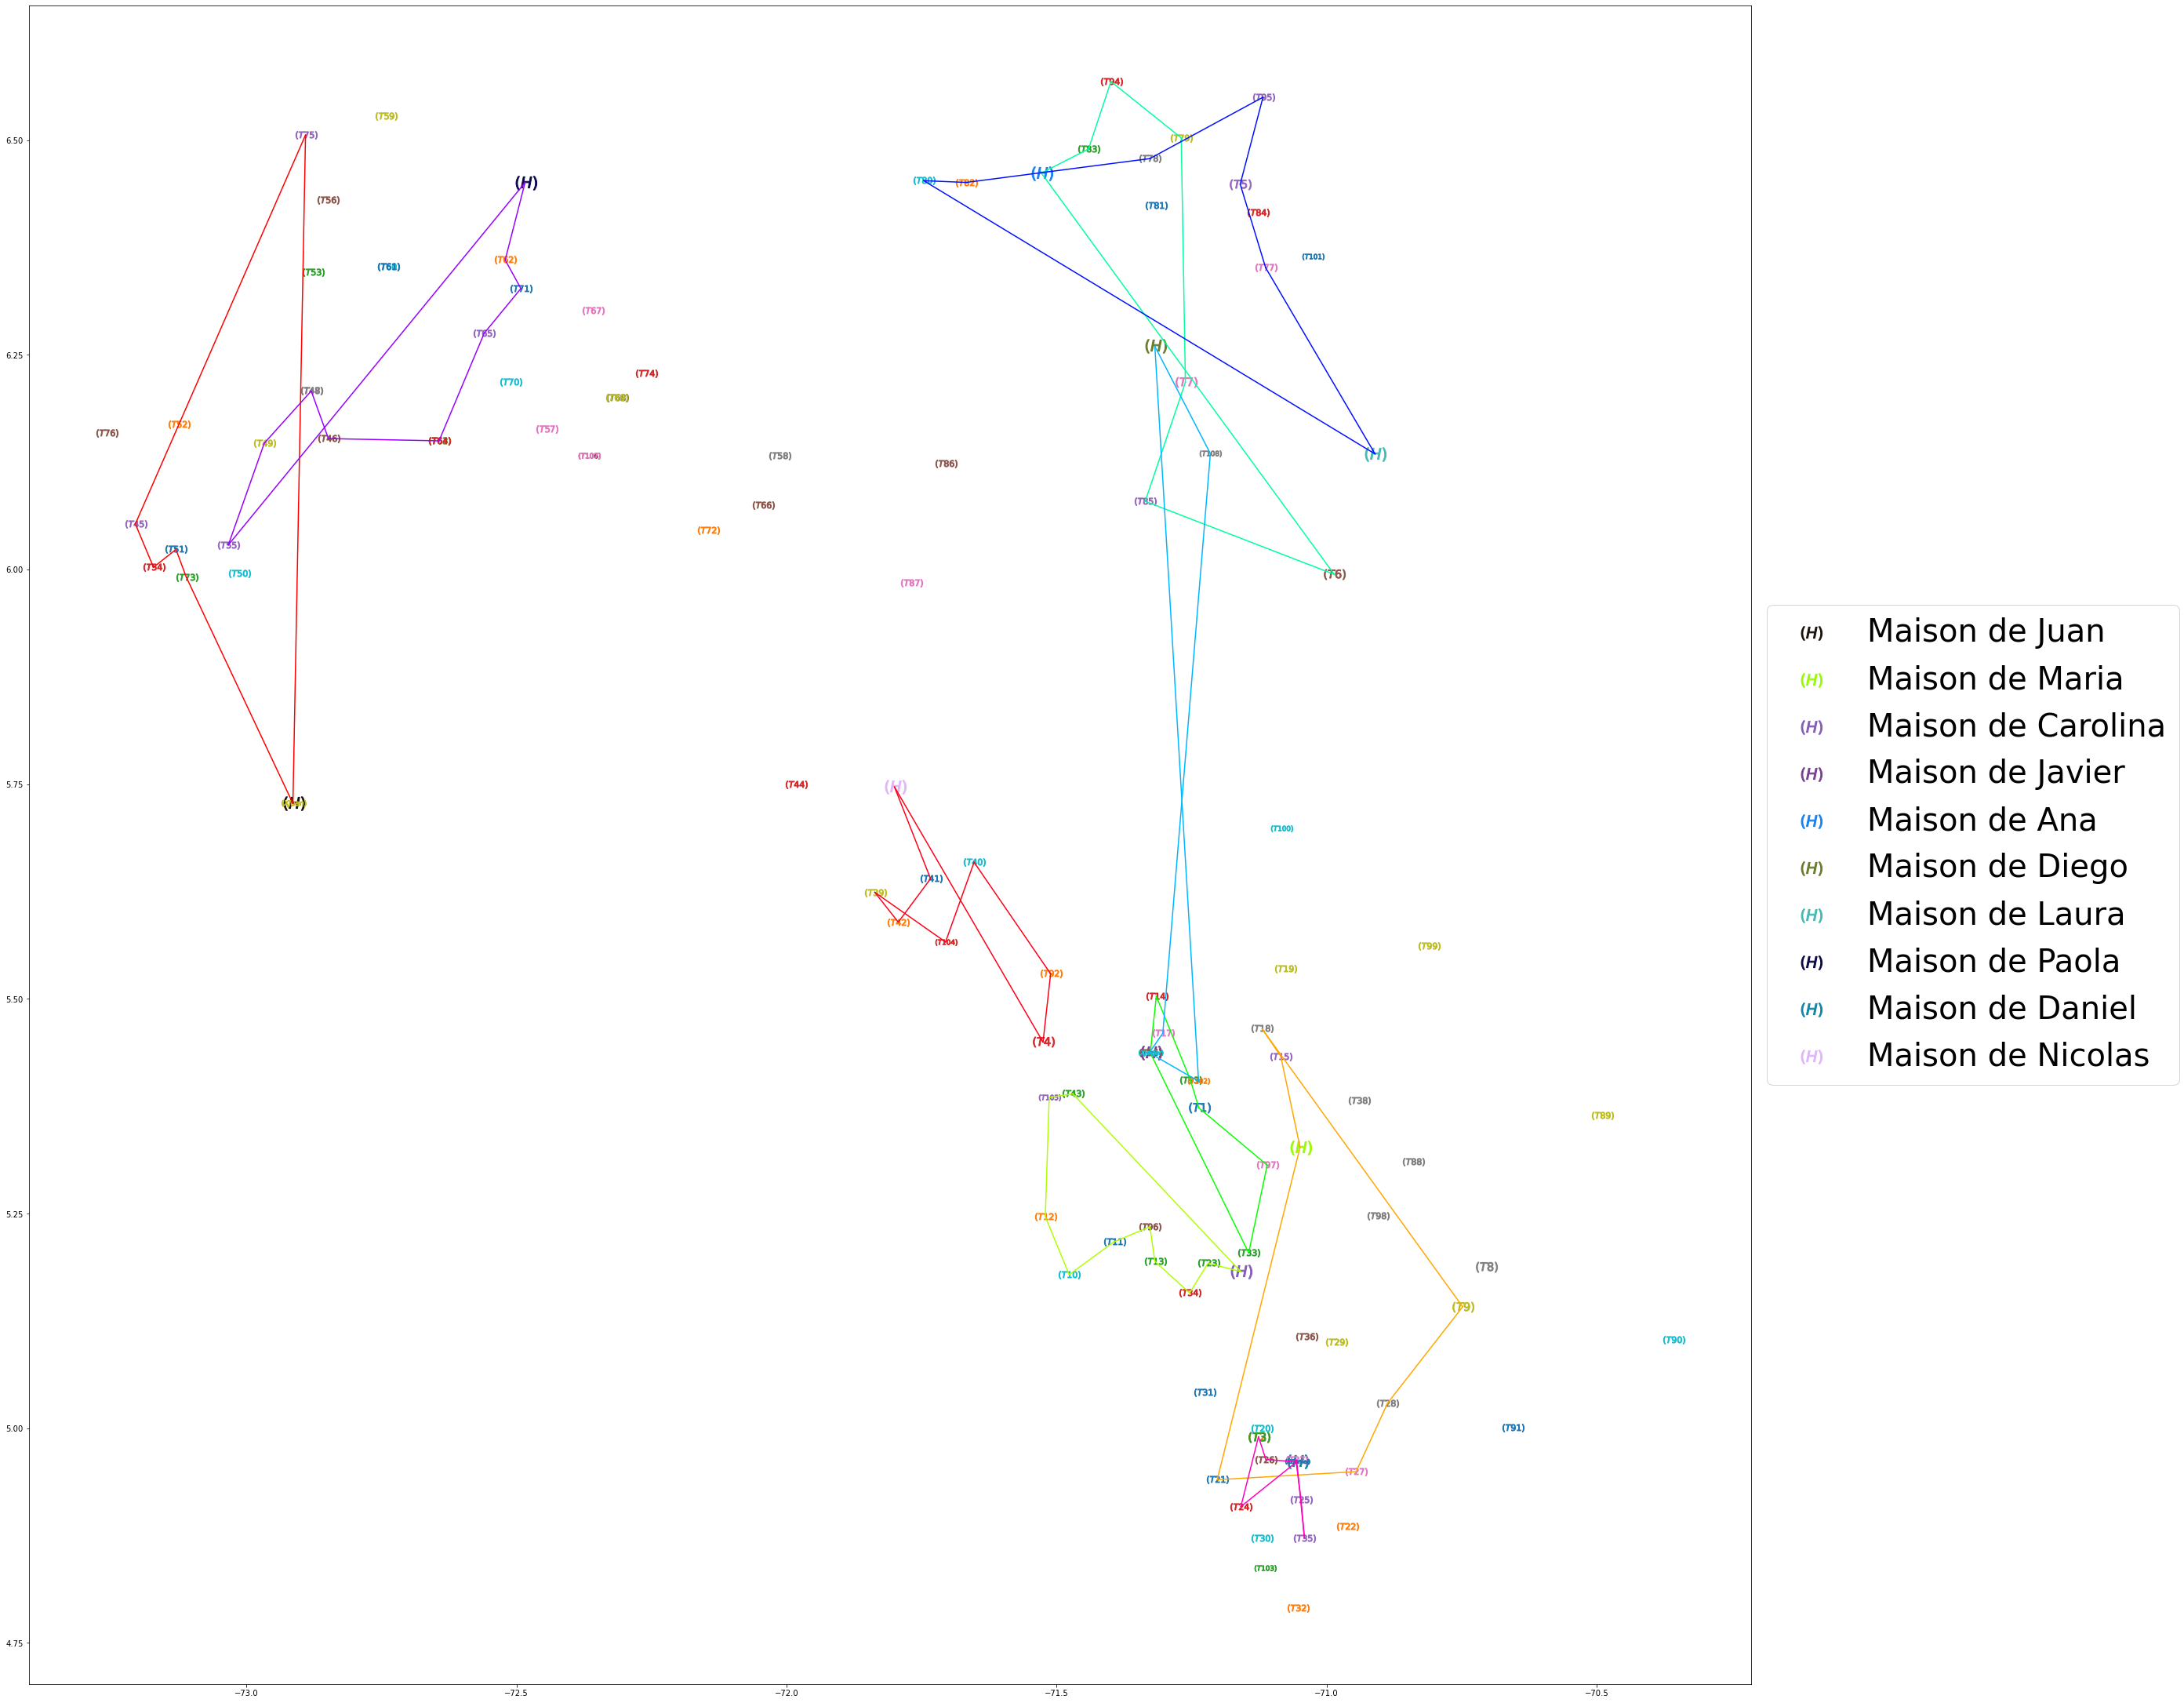

In [25]:
sol.plot_solution(marker=True)

In [26]:
print(f"Totally {sol.calculate_time()} minutes of work is done")
print(f"With total distance of {ceil(sol.calculate_distance())} km")

Totally 2955 minutes of work is done
With total distance of 1572 km


In [27]:
sol.employee_lunch_time

{0: 756,
 1: 757,
 2: 722,
 3: 745,
 4: 778,
 5: 778,
 6: 740,
 7: 750,
 8: 720,
 9: 776}